#### Notebook Workflow:
- importing packages used
- reading data
- EDA

In [684]:
import pandas as pd
import numpy as np
import pandas_profiling

In [685]:
pd.set_option("display.max_rows",30)
pd.set_option("display.max_columns",30)

In [686]:
dataset=pd.read_csv('data.csv')
submission=pd.read_csv('sample_submission.csv')

In [687]:
dataset.shape

(30697, 28)

In [688]:
dataset.isnull().sum(axis=1).value_counts()

2    10646
3     7987
1     6806
4     3671
5     1196
6      325
7       60
8        5
9        1
dtype: int64

In [689]:
dataset['team_name'].value_counts(dropna=False)

Manchester United    29162
NaN                   1535
Name: team_name, dtype: int64

##### Team Name - only one team name for no new info as team name and team id will have 1-to-1 mapping so this column is useless.

In [690]:
dataset[['team_name','remaining_min.1']].isnull().sum(axis=1).value_counts()

0    27700
1     2924
2       73
dtype: int64

In [691]:
dataset[['date_of_game','game_season']].isnull().sum(axis=1).value_counts()

0    23588
1     6806
2      303
dtype: int64

In [692]:
dataset.isnull().sum()

Unnamed: 0                   0
match_event_id            1563
location_x                1461
location_y                1540
remaining_min             1562
power_of_shot             1486
knockout_match            1517
game_season               5862
remaining_sec             1594
distance_of_shot          1567
is_goal                   6268
area_of_shot              1502
shot_basics               1575
range_of_shot             1564
team_name                 1535
date_of_game              1550
home/away                 1497
shot_id_number            1563
lat/lng                   1565
type_of_shot             15280
type_of_combined_shot    15417
match_id                     0
team_id                      0
remaining_min.1           1535
power_of_shot.1           1539
knockout_match.1          1493
remaining_sec.1           1539
distance_of_shot.1        1568
dtype: int64

In [ ]:
per=0.85
per_unique=1
ignore_list=[]

In [560]:
noo=['match_event_id', 'location_x', 'location_y',
       'remaining_min', 'power_of_shot', 'knockout_match', 'game_season',
       'remaining_sec', 'distance_of_shot', 'is_goal', 'area_of_shot',
       'shot_basics', 'range_of_shot', 'team_name', 'date_of_game',
       'home/away', 'lat/lng', 'type_of_shot',
       'type_of_combined_shot', 'match_id', 'team_id', 'remaining_min.1',
       'power_of_shot.1', 'knockout_match.1', 'remaining_sec.1',
       'distance_of_shot.1']

In [561]:
len(noo)

26

In [567]:
a=directlyMappedColumnRemover(dataset[noo].fillna('empty'),per=0.9,per_unique=1,ignore_list=['unique_count'])

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1164: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [569]:
mappings=pd.DataFrame(a,columns=noo,index=noo)

In [571]:
mappings.to_csv('head_to_head.csv')

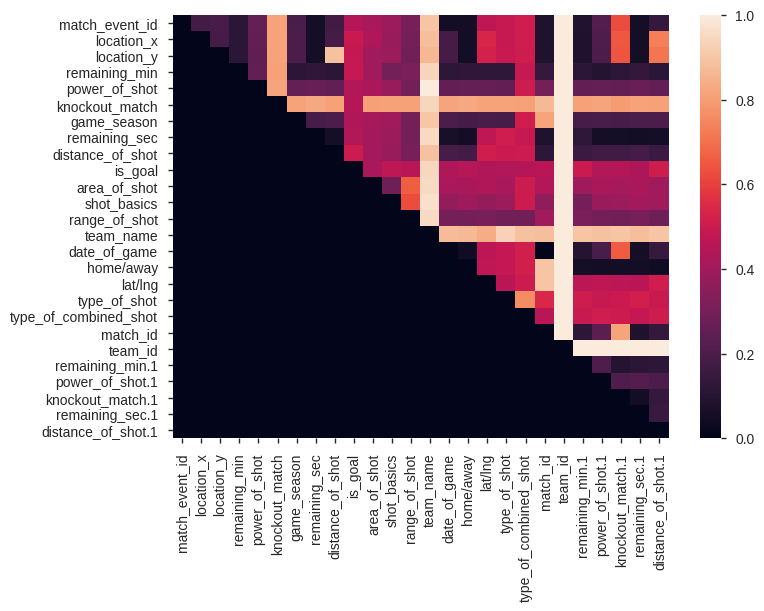

In [572]:
sns.heatmap(mappings)
plt.show()

In [566]:
def directlyMappedColumnRemover(df, per, per_unique, ignore_list):
    data = df.copy()
    #print('\ndirectlyMappedColumnRemover Started ! : ' + str(data.shape))
    arr=np.zeros((26,26))
    # For getting the count
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'unique_count'}, inplace=True)
    #print(data)
    columns = data.columns

    # To avoid date columns to participate
    #columns = [c for c in columns if 'date' not in c]
    columns = [c for c in columns if c not in ignore_list]
    #print(columns)
    removeColumns = []

    #print('\nColumns that are directly mapped : ')
    for i in range(0, len(columns) - 1):
        for j in range(i + 1, len(columns)):
            try:
                #count1 = data[data[~columns[i]].isnull()][columns[i]].nunique()
                #count2 = data[data[~columns[j]].isnull()][columns[j]].nunique()
                count1 = data[columns[i]].nunique()
                count2 = data[columns[j]].nunique()
            except:
                count1 = data[columns[i]].nunique()
                count2 = data[columns[j]].nunique()

            if count1 >= count2:
                col1 = columns[i]
                col2 = columns[j]
            else:
                col1 = columns[j]
                col2 = columns[i]
            #print(col1)
            #print(col2)
            # Getting the grouped dataframe
            grp_df = data.groupby([col1, col2], as_index=False).agg({'unique_count': 'count'})
            grp_df.rename(columns={'unique_count': 'count'}, inplace=True)
            grp_df.sort_values(by='count', ascending=False, inplace=True)
            grp_df.reset_index(drop=True, inplace=True)
            grp_df['cumsum'] = grp_df['count'].cumsum()

            try:
                grp_df['percentage'] = grp_df['cumsum'] / len(data)
            except ZeroDivisionError:
                pass
                #print('Zero Division Error')

            grp_df1 = grp_df[grp_df['percentage'] <= 1]

            # From the highest level column , take 90% of the uniques
            bb = pd.DataFrame(data[col1].value_counts()).reset_index()
            try:
                bb = bb[bb[col1] != 'nan']
            except:
                pass
            bb.columns = [col1, 'count']
            bb.sort_values(by='count', ascending=False, inplace=True)
            bb.reset_index(drop=True, inplace=True)
            bb['cumsum'] = bb['count'].cumsum()

            try:
                bb['percentage'] = bb['cumsum'] / len(data)
            except ZeroDivisionError:
                pass
                #print('Zero Division Error')

            bb1 = bb[bb['percentage'] <= per_unique]

            unique_col1 = bb1[col1].unique().tolist()

            f = 0
            #print(col1)
            for iKeys in unique_col1:
                count_prev = len(data[data[col1] == iKeys])
                count_curr = grp_df1.loc[grp_df1[col1] == iKeys, 'count'].values.tolist()
                count_curr = sorted(count_curr, reverse=True)[0]

                try:
                    ratio = count_curr / count_prev
                except ZeroDivisionError:
                    pass
                    #print('Zero Division Error')

                if ratio < per:
                    f = 1
                    break
            if f == 0:
                
                removeColumns.append(col2)
            arr[i][j]=ratio
    del data['unique_count']

    return arr

In [693]:
dataset['shot_id_number']=range(1,len(dataset['shot_id_number'])+1)

###### shot id number is running integer so can be filled directly

In [694]:
submission.head()

,shot_id_number,is_goal
0,1,0.1
1,8,0.1
2,17,0.1
3,20,0.1
4,33,0.1


In [695]:
output_label='is_goal'

In [696]:
train=dataset[~dataset[output_label].isnull()]
test=dataset[dataset[output_label].isnull()]

In [697]:
train.shape

(24429, 28)

In [698]:
test.shape

(6268, 28)

In [699]:
del train['Unnamed: 0']
del test['Unnamed: 0']

In [428]:
train.to_csv('train.csv')
test.to_csv('test.csv')

In [429]:
profile = pandas_profiling.ProfileReport(train)

### Column Overview using pandas profiling

In [430]:
profile

Number of variables,28
Number of observations,24429
Total Missing (%),7.7%
Total size in memory,5.2 MiB
Average record size in memory,224.0 B
Numeric,13
Categorical,10
Boolean,1
Date,0
Text (Unique),0
Rejected,4


In [431]:
train['match_event_id'].nunique()

614

In [432]:
train.columns

Index(['match_event_id', 'location_x', 'location_y', 'remaining_min',
       'power_of_shot', 'knockout_match', 'game_season', 'remaining_sec',
       'distance_of_shot', 'is_goal', 'area_of_shot', 'shot_basics',
       'range_of_shot', 'team_name', 'date_of_game', 'home/away',
       'shot_id_number', 'lat/lng', 'type_of_shot', 'type_of_combined_shot',
       'match_id', 'team_id', 'remaining_min.1', 'power_of_shot.1',
       'knockout_match.1', 'remaining_sec.1', 'distance_of_shot.1'],
      dtype='object')

In [433]:
train['area_of_shot'].value_counts(dropna=False)#cat

Center(C)                10177
Right Side Center(RC)     3616
Right Side(R)             3504
Left Side Center(LC)      3031
Left Side(L)              2848
NaN                       1182
Mid Ground(MG)              71
Name: area_of_shot, dtype: int64

In [434]:
train[['remaining_min','remaining_sec','remaining_min.1','remaining_sec.1']].head()#num

,remaining_min,remaining_sec,remaining_min.1,remaining_sec.1
1,10.0,22.0,10.00,22.0000
2,7.0,45.0,92.64,63.7216
3,6.0,52.0,NaN,52.0000
4,NaN,19.0,42.64,19.0000
5,9.0,32.0,9.00,NaN


In [435]:
train[['remaining_min','remaining_sec','remaining_min.1','remaining_sec.1']].describe()#num

,remaining_min,remaining_sec,remaining_min.1,remaining_sec.1
count,23185.000000,23179.000000,23220.000000,23229.000000
mean,4.881044,28.289788,18.151628,38.849996
std,3.454113,17.508097,29.432083,29.753285
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,13.000000,3.000000,17.000000
50%,5.000000,28.000000,6.000000,35.000000
75%,8.000000,43.000000,11.000000,52.000000
max,11.000000,59.000000,128.761600,144.785600


In [436]:
train['type_of_shot'].value_counts(dropna=False).head()#cat-58

NaN          12136
shot - 39     1145
shot - 36     1042
shot - 4       875
shot - 15      554
Name: type_of_shot, dtype: int64

In [437]:
train['type_of_combined_shot'].value_counts(dropna=False).head()#cat -7

NaN         12293
shot - 3     9338
shot - 4     2129
shot - 1      470
shot - 5       72
Name: type_of_combined_shot, dtype: int64

In [438]:
train['team_name'].value_counts(dropna=False).head()#cat -2

Manchester United    23217
NaN                   1212
Name: team_name, dtype: int64

In [439]:
train['team_id'].value_counts(dropna=False).head()#cat -constant

1610612747    24429
Name: team_id, dtype: int64

In [440]:
train['shot_id_number'].head()# identifier

1    2
2    3
3    4
4    5
5    6
Name: shot_id_number, dtype: int64

In [441]:
train['shot_basics'].value_counts(dropna=False)#cat -8

Mid Range          9488
Goal Area          5323
Penalty Spot       4245
Goal Line          3515
NaN                1283
Right Corner        302
Left Corner         216
Mid Ground Line      57
Name: shot_basics, dtype: int64

In [442]:
train['range_of_shot'].value_counts(dropna=False)#cat -6

Less Than 8 ft.    7064
16-24 ft.          6220
8-16 ft.           5076
24+ ft.            4751
NaN                1248
Back Court Shot      70
Name: range_of_shot, dtype: int64

In [443]:
train[['power_of_shot','power_of_shot.1']].head()#num

,power_of_shot,power_of_shot.1
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,2.0,2.0
5,3.0,3.0


In [444]:
train['match_id'].nunique()# id

1558

In [445]:
train[['match_id','knockout_match']].head()

,match_id,knockout_match
1,20000012,0.0
2,20000012,0.0
3,20000012,0.0
4,20000012,0.0
5,20000012,0.0


In [446]:
train['knockout_match'].value_counts(dropna=False)

 0.0    19834
 1.0     3383
NaN      1212
Name: knockout_match, dtype: int64

In [447]:
train['knockout_match.1'].value_counts(dropna=False).head(8)

 0.000      15776
 1.000       2695
NaN          1214
 38.608        29
 132.608       28
 95.608        28
 87.608        25
 125.928       25
Name: knockout_match.1, dtype: int64

In [448]:
train['match_event_id'].value_counts(dropna=False).head(8)#id

NaN       1240
 2.0        98
 4.0        78
 11.0       75
 17.0       72
 8.0        72
 278.0      71
 313.0      70
Name: match_event_id, dtype: int64

In [449]:
train[['location_x','location_y']].head()#numeric

,location_x,location_y
1,-157.0,0.0
2,-101.0,135.0
3,138.0,175.0
4,0.0,0.0
5,-145.0,-11.0


In [450]:
train['lat/lng'].value_counts(dropna=False).head(8)#cat - try to see trend

42.982923, -71.446094     11256
NaN                        1247
29.444994, -98.524120       771
33.552026, -112.071667      696
38.567296, -121.456638      681
39.739968, -104.954013      632
29.740325, -95.365762       606
45.539131, -122.651648      604
Name: lat/lng, dtype: int64

In [451]:
train['home/away'].value_counts(dropna=False).head()# @ replace with vs.

NaN             1214
MANU @ SAS       767
MANU @ PHX       701
MANU vs. SAS     693
MANU @ SAC       686
Name: home/away, dtype: int64

In [452]:
train['home/away'].nunique()#can be reduced vs. replaced with @

74

In [453]:
train['date_of_game'].head()# date col

1    2000-10-31
2    2000-10-31
3    2000-10-31
4    2000-10-31
5    2000-10-31
Name: date_of_game, dtype: object

In [454]:
train['is_goal'].value_counts(dropna=False)

0.0    13550
1.0    10879
Name: is_goal, dtype: int64

In [455]:
train[['distance_of_shot','distance_of_shot.1']].head()#numerical

,distance_of_shot,distance_of_shot.1
1,35.0,35.0
2,36.0,54.4
3,42.0,42.0
4,20.0,20.0
5,34.0,34.0


In [456]:
train['game_season'].value_counts(dropna=False)#-21 vals

NaN        4632
2005-06    1496
2002-03    1429
2008-09    1416
2007-08    1403
2009-10    1374
2001-02    1310
2006-07    1233
2000-01    1195
2010-11    1153
2011-12    1093
2003-04    1047
2012-13    1044
1999-00     992
2004-05     871
2015-16     714
1997-98     627
1998-99     590
2014-15     474
1996-97     291
2013-14      45
Name: game_season, dtype: int64

In [457]:
# can see .1 vs direct pattern
# can see x vs y pattern on chart
# see interactions and interactions history
#make multi level features a lot
#see what things are necessary for football goals
# look for interactions 
# add age feature that shows the performance as well.

In [459]:
# take numericals 
num=['remaining_min','remaining_sec','remaining_min.1','remaining_sec.1','power_of_shot','power_of_shot.1',
    'distance_of_shot','distance_of_shot.1','location_x','location_y']
cat=['area_of_shot','game_season','home/away','lat/lng','knockout_match','knockout_match.1',
    'range_of_shot','shot_basics','team_name','type_of_combined_shot','type_of_shot']

In [460]:
len(num)

10

In [461]:
len(cat)

11

In [462]:
set(train.columns)-set(num+cat)
#team_id constant
#date used
#is_goal output
#shot_id_number - identifier


{'date_of_game',
 'is_goal',
 'match_event_id',
 'match_id',
 'shot_id_number',
 'team_id'}

In [463]:
train['match_id'].nunique()# too much cardinaity can look for ensemble

1558

In [464]:
train['match_event_id'].nunique()#still can be used

614

In [465]:
#date-minimum feature

In [466]:
train[num].isnull().sum()

remaining_min         1244
remaining_sec         1250
remaining_min.1       1209
remaining_sec.1       1200
power_of_shot         1200
power_of_shot.1       1208
distance_of_shot      1257
distance_of_shot.1    1244
location_x            1156
location_y            1245
dtype: int64

In [467]:
#train[num].fillna(-999,inplace=True)

In [468]:
for x in num:
    train[x]=train[x].fillna(-99.0)

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [469]:
cat

['area_of_shot',
 'game_season',
 'home/away',
 'lat/lng',
 'knockout_match',
 'knockout_match.1',
 'range_of_shot',
 'shot_basics',
 'team_name',
 'type_of_combined_shot',
 'type_of_shot']

In [470]:
train['area_of_shot_fill']=train['area_of_shot'].fillna('empty')

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [471]:
train['area_of_shot_fill_enc']=train.area_of_shot_fill.map(train.groupby(['area_of_shot_fill']).is_goal.mean())

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [472]:
train['game_season_fill']=train['game_season'].fillna('empty')

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [473]:
#can be filled with the date given dude

In [474]:
train['game_season_fill_enc']=train.game_season_fill.map(train.groupby(['game_season_fill']).is_goal.mean())

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [475]:
for x in cat:
    train[x+'_fill']=train[x].fillna('empty')

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [476]:
train['home/away_fill'].nunique()

75

In [477]:
train['home/away_fill']=train['home/away_fill'].str.replace("@","vs.")

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [478]:
train['home/away_fill'].nunique()

39

In [479]:
train['home/away_fill_enc']=train['home/away_fill'].map(train.groupby(['home/away_fill']).is_goal.mean())

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [480]:
train['lat/lng_fill'].value_counts()# need to take in different form

42.982923, -71.446094     11256
empty                      1247
29.444994, -98.524120       771
33.552026, -112.071667      696
38.567296, -121.456638      681
39.739968, -104.954013      632
29.740325, -95.365762       606
45.539131, -122.651648      604
46.667324, -94.419250       557
40.774891, -111.930790      551
37.754130, -122.437947      525
32.757824, -96.786653       485
34.189593, -118.471724      483
35.103812, -89.964007       399
42.330507, -71.074655       394
47.633181, -122.308343      324
28.549237, -81.372780       306
39.993941, -75.143458       306
42.379455, -83.115635       280
40.708999, -73.872430       252
43.717098, -79.395917       252
40.361408, -86.186052       249
41.484971, -81.671552       247
38.919619, -77.015211       245
41.845137, -87.660450       239
35.492151, -97.519011       235
33.768092, -84.393817       225
25.790710, -80.207819       218
43.062206, -87.944754       217
30.018061, -90.022651       214
40.643505, -73.939507       201
35.26204

In [481]:
train['lat/lng_fill_enc']=train['lat/lng_fill'].map(train.groupby(['lat/lng_fill']).is_goal.mean())

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Mean encoding for each category

In [482]:
for m in ['knockout_match','knockout_match.1','range_of_shot','shot_basics',
          'team_name','type_of_combined_shot','type_of_shot']:
    train[m+'_fill_enc']=train[m+'_fill'].map(train.groupby([m+'_fill']).is_goal.mean())

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [483]:
mini=pd.to_datetime(train['date_of_game']).min()

In [484]:
def change_to_int(x):
    try:
        return int(x)
    except:
        return 0

In [485]:
train['date_of_game_t']=(pd.to_datetime(train['date_of_game'])-mini).apply(lambda x: change_to_int(str(x).split()[0]))

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Creating shot angle visualization of X and Y cordinates shows it's importance

In [486]:
train['shot_angle']=np.where(train['location_x']!=0,train['location_y']/train['location_x'],0)

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Euclidean distance of the shot

In [487]:
train['shot_distance']=np.sqrt(np.power(train['location_x'],2)+np.power(train['location_y'],2))

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [488]:
def create_features(df):
    df['area_of_shot_fill']=df['area_of_shot'].fillna('empty')
    df['area_of_shot_fill_enc']=df.area_of_shot_fill.map(train.groupby(['area_of_shot_fill']).is_goal.mean())
    df['game_season_fill']=df['game_season'].fillna('empty')
    df['game_season_fill_enc']=df.game_season_fill.map(train.groupby(['game_season_fill']).is_goal.mean())
    for x in cat:
        df[x+'_fill']=df[x].fillna('empty')
    df['home/away_fill']=df['home/away_fill'].str.replace("@","vs.")
    df['shot_angle']=np.where(df['location_x']!=0,df['location_y']/df['location_x'],0)
    df['shot_distance']=np.sqrt(np.power(df['location_x'],2)+np.power(df['location_y'],2))
    df['home/away_fill_enc']=df['home/away_fill'].map(train.groupby(['home/away_fill']).is_goal.mean())
    df['lat/lng_fill_enc']=df['lat/lng_fill'].map(train.groupby(['lat/lng_fill']).is_goal.mean())
    for m in ['knockout_match','knockout_match.1','range_of_shot','shot_basics',
          'team_name','type_of_combined_shot','type_of_shot']:
        df[m+'_fill_enc']=df[m+'_fill'].map(train.groupby([m+'_fill']).is_goal.mean())
    mini=pd.to_datetime(train['date_of_game']).min()
    df['date_of_game_t']=(pd.to_datetime(df['date_of_game'])-mini).apply(lambda x: change_to_int(str(x).split()[0]))
    return df

In [489]:
test=create_features(test)

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [490]:
for x in num:
    test[x]=test[x].fillna(-99.0)

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [491]:
test['shot_id_number'].head()

0      1
7      8
16    17
19    20
21    22
Name: shot_id_number, dtype: int64

In [492]:
from sklearn.ensemble import RandomForestClassifier

In [493]:
rf=RandomForestClassifier()

In [494]:
features=num+['area_of_shot_fill_enc',
 'game_season_fill_enc',
 'home/away_fill_enc',
 'lat/lng_fill_enc',
 'knockout_match_fill_enc',
 'knockout_match.1_fill_enc',
 'range_of_shot_fill_enc',
 'shot_basics_fill_enc',
 'team_name_fill_enc',
 'type_of_combined_shot_fill_enc',
 'type_of_shot_fill_enc',
 'date_of_game_t','shot_angle','shot_distance']

In [495]:
rf.fit(train[features],train['is_goal'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [496]:
test[features].isnull().sum()

remaining_min                       0
remaining_sec                       0
remaining_min.1                     0
remaining_sec.1                     0
power_of_shot                       0
power_of_shot.1                     0
distance_of_shot                    0
distance_of_shot.1                  0
location_x                          0
location_y                          0
area_of_shot_fill_enc               0
game_season_fill_enc                0
home/away_fill_enc                  0
lat/lng_fill_enc                    0
knockout_match_fill_enc             0
knockout_match.1_fill_enc           6
range_of_shot_fill_enc              0
shot_basics_fill_enc                0
team_name_fill_enc                  0
type_of_combined_shot_fill_enc      0
type_of_shot_fill_enc               0
date_of_game_t                      0
shot_angle                        542
shot_distance                     585
dtype: int64

In [497]:
out=pd.DataFrame()
out['is_goal']=rf.predict_proba(test[features].fillna(0))[:,1]

In [498]:
out.shape

(6268, 1)

In [499]:
test['shot_id_number'].shape

(6268,)

In [500]:
out=pd.concat([test['shot_id_number'].reset_index(drop=True),out['is_goal']],axis=1)

In [501]:
out.shape

(6268, 2)

In [502]:
out.shape

(6268, 2)

In [503]:
test.shape

(6268, 52)

In [504]:
del submission['is_goal']

In [505]:
final=pd.merge(submission,out,how='left',on='shot_id_number')

In [516]:
final.to_csv('sub_4.csv',index=False)

In [ ]:
final

# creating cross validation pipeline

In [506]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [508]:
train[features].shape

(24429, 24)

In [509]:
def printing_Kfold(x_data,y_data,seed=2,split=5):
    skf = StratifiedKFold(n_splits=split,shuffle=True,random_state=seed)
    metric_score = []
    for train_index,test_index in skf.split(x_data,y_data):
        X_train, X_test = x_data[train_index], x_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]
        lr = RandomForestClassifier()#(n_estimators=100,max_depth=18,min_samples_leaf=50,random_state=seed)
        lr.fit(X_train,y_train)
        pred = lr.predict(X_test)
        pred_prob = lr.predict_proba(X_test)[:,1]
        #print('classification report:')
        #print(metrics.classification_report(y_test,pred))
        print("Metric:")
        MAE=mean_absolute_error(y_test,pred_prob)
        score=1/(1+MAE)
        print(score)
        metric_score.append(score)
    print("average scores:")
    print(sum(metric_score)/len(metric_score))

In [512]:
importance=pd.DataFrame()
importance['features']=features
importance['imp']=rf.feature_importances_

In [515]:
importance.sort_values('imp')

,features,imp
18,team_name_fill_enc,0.005328
14,knockout_match_fill_enc,0.011303
16,range_of_shot_fill_enc,0.013557
17,shot_basics_fill_enc,0.015161
10,area_of_shot_fill_enc,0.015676
19,type_of_combined_shot_fill_enc,0.025112
4,power_of_shot,0.026768
6,distance_of_shot,0.035345
15,knockout_match.1_fill_enc,0.041733
5,power_of_shot.1,0.041809


In [511]:
rf.feature_importances_

array([0.04297229, 0.05974296, 0.05298007, 0.06635552, 0.02676756,
       0.04180858, 0.0353454 , 0.0440045 , 0.05328814, 0.05259082,
       0.01567618, 0.04238763, 0.05521037, 0.04335589, 0.01130348,
       0.04173332, 0.01355667, 0.01516095, 0.0053277 , 0.02511171,
       0.05662281, 0.07040935, 0.05883628, 0.06945182])

In [510]:
printing_Kfold(train[features].values,train['is_goal'].values)#0.71 - 1.582
#68.6489
#68.98 - no depth

Metric:
0.6903275028963802
Metric:
0.6865155751640415
Metric:
0.6926271919254923
Metric:
0.6913629160063391
Metric:
0.6881929476071734
average scores:
0.6898052267198853


In [ ]:
#submission -1 
#average scores:
#0.6907029369476911

## EDA-2

In [404]:
% matplotlib inline

In [394]:
import seaborn as sns

In [395]:
import matplotlib.pyplot as plt

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/divyam.arora/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


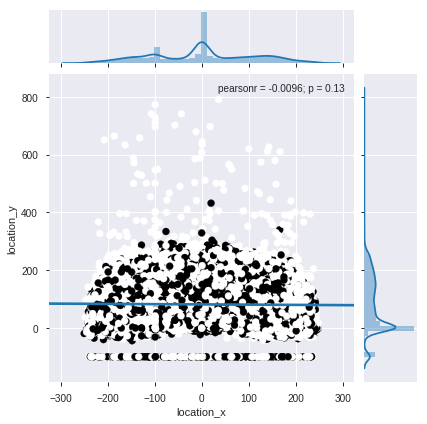

In [406]:
g = sns.jointplot(train['location_x'], train['location_y'], kind='reg', scatter = False )
g.ax_joint.scatter(train['location_x'], train['location_y'], c=train['is_goal'])


### plot shows angles and distance can be calculated w.r.t goal which is at (0,0)

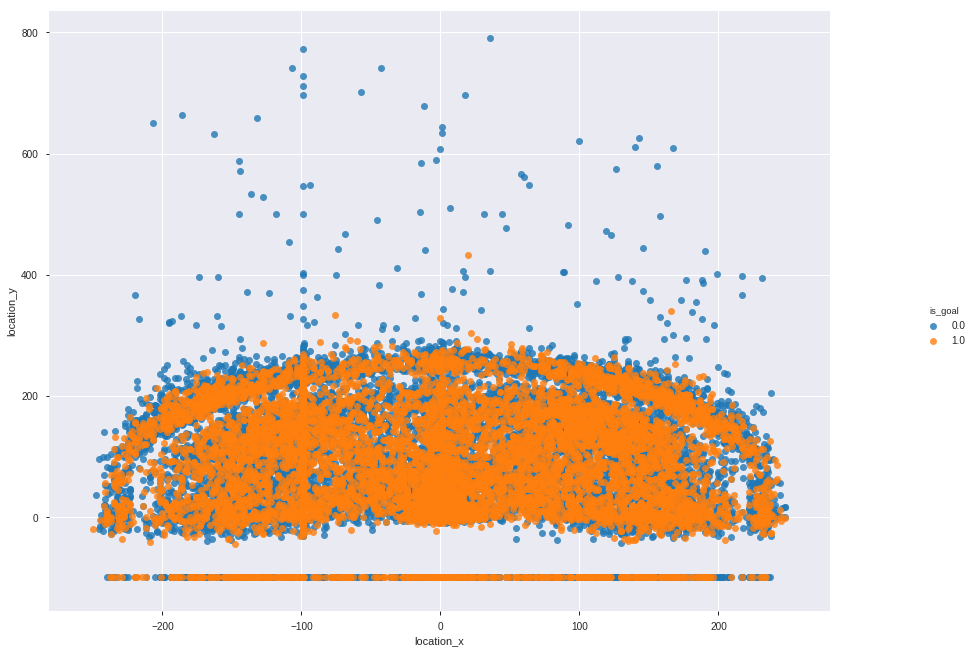

In [408]:
sns.lmplot('location_x', 'location_y', train, hue='is_goal', fit_reg=False)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

In [ ]:
#'location_y' and 'distance_of_shot'
#highest correlation with output
#angle to goal = location_y/location_x
#distance from goal = euclid of y and x`

In [ ]:
#age from 1985

### using multiple column versions to build actual column

In [580]:
def change_remain(x,y):
    if x==y:
        return x
    elif (int(x)==x)& (x!=-99.0):
        return x
    elif (int(y)==y) & (y!=-99.0):
        return y
    else:
        return x

In [583]:
train['remaining_min_f']=train.apply(lambda x: change_remain(x['remaining_min'],x['remaining_min.1']),axis=1)

In [585]:
train['remaining_sec_f']=train.apply(lambda x: change_remain(x['remaining_sec'],x['remaining_sec.1']),axis=1)

In [590]:
train['power_of_shot_f']=train.apply(lambda x: change_remain(x['power_of_shot'],x['power_of_shot.1']),axis=1)

In [595]:
train['knockout_match.1'].fillna(-99.0,inplace=True)

In [596]:
train['knockout_match'].fillna(-99.0,inplace=True)

In [600]:
train['knockout_match_f']=train.apply(lambda x: change_remain(x['knockout_match'],x['knockout_match.1']),axis=1)

In [710]:
train[['distance_of_shot','distance_of_shot.1']].fillna(-99.0,inplace=True)

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [712]:
nds=['distance_of_shot','distance_of_shot.1']
for x in nds:
    train[x]=train[x].fillna(-99.0)

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [713]:
train[nds].isnull().sum()

distance_of_shot      0
distance_of_shot.1    0
dtype: int64

In [714]:
train['distance_of_shot_f']=train.apply(lambda x: change_remain(x['distance_of_shot'],x['distance_of_shot.1']),axis=1)

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [612]:
 train['team_name'].fillna('Manchester United',inplace=True)

In [613]:
train.team_name.value_counts()

Manchester United    24429
Name: team_name, dtype: int64

In [614]:
train.match_id.isnull().sum()

0

## Match id and lat/lng and date_of_game

In [616]:
train[['match_id','lat/lng']].shape

(24429, 2)

In [618]:
train[['match_id','lat/lng']].isnull().sum()

match_id       0
lat/lng     1247
dtype: int64

In [619]:
24429-23182

1247

In [617]:
train[['match_id','lat/lng']].dropna().shape

(23182, 2)

In [620]:
a=train[['match_id','lat/lng']].dropna()

In [621]:
a['n']=train['match_id'].astype(str)+'_'+train['lat/lng'].astype(str)

In [623]:
a.n.nunique()

1558

In [624]:
a.match_id.nunique()

1558

In [632]:
train['lat/lng']=train.match_id.map(a.groupby(['match_id'])['lat/lng'].first())

In [635]:
train['home/away_fill'].head()# one to one with match_id

1    MANU vs. POR
2           empty
3    MANU vs. POR
4    MANU vs. POR
5    MANU vs. POR
Name: home/away_fill, dtype: object

In [636]:
a=train[['match_id','date_of_game']].dropna()

In [637]:
a.shape

(23192, 2)

In [638]:
train[['match_id','date_of_game']].isnull().sum()

match_id           0
date_of_game    1237
dtype: int64

In [640]:
train.shape

(24429, 57)

In [642]:
a['n']=train['match_id'].astype(str)+'_'+train['date_of_game'].astype(str)

In [644]:
a.nunique()

match_id        1557
date_of_game    1557
n               1557
dtype: int64

In [667]:
def fill_data_with_corresponding_values(df,a1,b1):
    fill_table=pd.DataFrame(columns=[a1,b1+'_fill'])
    for x in df[a1].unique().tolist():
        if len(df.loc[(df[a1]==x)&(~df[b1].isnull()),b1])!=0:
            x_value=df.loc[(df[a1]==x)&(~df[b1].isnull()),b1].values[0]
        else:
            x_value=np.nan
        df2 = pd.DataFrame({a1:[x], b1+'_fill':[x_value]}) 
        fill_table=fill_table.append(df2)
    fill_table[a1]=fill_table[a1].astype(int).astype(str)
    df[a1]=df[a1].astype(int).astype(str)
    return pd.merge(df,fill_table,how='left',on=a1)    

In [668]:
new_df=fill_data_with_corresponding_values(train,'match_id','date_of_game')

In [681]:
train['game_season_new']=pd.to_datetime(new_df['date_of_game']).dt.year

In [ ]:
#game season is year of date

In [715]:
lastset=train[['match_event_id','area_of_shot','shot_basics','range_of_shot','type_of_shot',
       'type_of_combined_shot','match_id','distance_of_shot_f','location_x','location_y']]

In [716]:
lastset.isnull().sum()

match_event_id            1240
area_of_shot              1182
shot_basics               1283
range_of_shot             1248
type_of_shot             12136
type_of_combined_shot    12293
match_id                     0
distance_of_shot_f           0
location_x                1156
location_y                1245
dtype: int64

In [704]:
lastset.isnull().sum(axis=1).value_counts()

1    17039
2     6278
3     1012
4       91
5        9
dtype: int64

In [717]:
lastset['distance_of_shot_f']=lastset['distance_of_shot_f'].replace(-99.0,np.nan)

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [721]:
lastset.groupby(['range_of_shot']).agg({'distance_of_shot_f':{'d_min':'min','d_mean':'mean','d_max':'max','size':'count'}})
#clear distinction between values

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


distance_of_shot_f                       
                             d_min     d_mean d_max  size
range_of_shot                                            
16-24 ft.                     36.0  38.552195  43.0  6150
24+ ft.                       42.0  45.233078  65.0  4698
8-16 ft.                      28.0  31.985423  36.0  5008
Back Court Shot               60.0  75.228571  99.0    70
Less Than 8 ft.               20.0  21.720080  28.0  6977

In [720]:
lastset.range_of_shot.value_counts().index

Index(['Less Than 8 ft.', '16-24 ft.', '8-16 ft.', '24+ ft.',
       'Back Court Shot'],
      dtype='object')

In [724]:
import math

In [732]:
def fill_range(distance,range_of_shot):
    if (range_of_shot=='empty'):
        if (distance==-99.0):
            return np.nan
        elif (distance<=28.0)&(distance>0.0):
            return 'Less Than 8 ft.'
        elif (distance<=36.0):
            return '8-16 ft.'
        elif (distance<=43.0):
            return '16-24 ft.'
        elif (distance<=65.0):
            return '24+ ft.'
        elif (distance>65.0):
            return 'Back Court Shot'
    else:
        return range_of_shot

In [731]:
lastset['distance_of_shot_f']=lastset['distance_of_shot_f'].fillna(-99.0)
lastset['range_of_shot']=lastset['range_of_shot'].fillna('empty')

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [739]:
lastset['range_of_shot_new']=lastset.apply(lambda x: fill_range(x['distance_of_shot_f'],x['range_of_shot']),axis=1)

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [740]:
lastset[['location_x','location_y']].describe()

,location_x,location_y
count,23273.000000,23184.000000
mean,7.494178,91.461180
std,110.126457,88.041628
min,-250.000000,-44.000000
25%,-67.000000,4.000000
50%,0.000000,74.000000
75%,95.000000,160.000000
max,248.000000,791.000000


In [746]:
lastset[['type_of_shot','type_of_combined_shot']].isnull().sum()/len(lastset)

type_of_shot             0.496787
type_of_combined_shot    0.503213
dtype: float64

In [747]:
0.496787+0.503213

1.0

In [749]:
lastset[['type_of_shot','type_of_combined_shot']].isnull().sum(axis=1).value_counts()

1    24429
dtype: int64

In [760]:
lastset['type_of_shot_c']=lastset['type_of_shot'].apply(str).apply(lambda x: 'empty' if (x=='nan') else 'c_'+x)
lastset['type_of_shot_fill']=lastset['type_of_shot'].fillna('empty')

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [763]:
lastset['type_of_combined_shot']=lastset['type_of_combined_shot'].fillna('empty')

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [764]:
lastset['shot_type_comb']=np.where(lastset['type_of_combined_shot']=='empty',lastset['type_of_shot_fill'],lastset['type_of_combined_shot'])

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [767]:
lastset['shot_type_diff']=np.where(lastset['type_of_combined_shot']=='empty',lastset['type_of_shot_c'],lastset['type_of_combined_shot'])

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [771]:
lastset[['match_event_id','area_of_shot','shot_basics']].isnull().sum(axis=1).value_counts()

0    20911
1     3336
2      177
3        5
dtype: int64

In [ ]:
#match id to match event id rank transformation use it

In [773]:
lastset[['area_of_shot','shot_basics']].isnull().sum(axis=1).value_counts()

0    22033
1     2327
2       69
dtype: int64

In [787]:
lam=lastset.groupby(['shot_basics','area_of_shot'],as_index=False).agg({'location_x':{'min','max'},'location_y':{'min','max'}})

In [790]:
lam.columns=['shot_basics','area_of_shot','xmax','xmin','ymax','ymin']

In [807]:
def change_area_of_shot(data,table):
    New_Data=pd.DataFrame(columns=data.columns.tolist())
    for index,row in data.iterrows():
        if (row['area_of_shot']!='empty'):
            New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)
        else:
            if (row['shot_basics']=='empty'):
                New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)
            else:
                space=table[table['shot_basics']==row['shot_basics']]
                flag=0
                for index_space,row_space in space.iterrows():
                    if ((row['location_x']<=row_space['xmax'])& (row['location_x']>=row_space['xmin']) & (row['location_y']<=row_space['ymax'])& (row['location_y']>=row_space['ymin'])):
                        row['area_of_shot']=row_space['area_of_shot']
                        New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)
                        flag=1
                        break
                if flag==0:
                    New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)    
    return New_Data

In [905]:
lam

,shot_basics,area_of_shot,xmax,xmin,ymax,ymin
0,Goal Area,Center(C),39.0,-39.0,39.0,-23.0
1,Goal Line,Center(C),80.0,-79.0,138.0,-35.0
2,Goal Line,Left Side(L),-42.0,-80.0,133.0,17.0
3,Goal Line,Right Side(R),80.0,41.0,135.0,-26.0
4,Left Corner,Left Side(L),-221.0,-250.0,87.0,-35.0
5,Mid Ground Line,Mid Ground(MG),190.0,-207.0,791.0,432.0
6,Mid Range,Center(C),73.0,-75.0,235.0,139.0
7,Mid Range,Left Side Center(LC),-51.0,-183.0,220.0,97.0
8,Mid Range,Left Side(L),-81.0,-218.0,136.0,-44.0
9,Mid Range,Right Side Center(RC),188.0,53.0,222.0,96.0


In [796]:
lastset['area_of_shot']=lastset['area_of_shot'].fillna('empty')
lastset['shot_basics']=lastset['shot_basics'].fillna('empty')

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [822]:
new_lastset=change_area_of_shot(lastset,lam)

In [814]:
(new_lastset['area_of_shot']=='empty').value_counts()

False    24247
True       182
Name: area_of_shot, dtype: int64

In [815]:
(lastset['area_of_shot']=='empty').value_counts()

False    23247
True      1182
Name: area_of_shot, dtype: int64

In [823]:
new_lastset=pd.concat([new_lastset,train['is_goal']],axis=1)

In [824]:
new_lastset.groupby(['shot_basics','area_of_shot']).agg({'is_goal':{'sum','count'}})

is_goal      
                                          sum count
shot_basics     area_of_shot                       
Goal Area       Center(C)              3273.0  5298
                empty                    17.0    25
Goal Line       Center(C)              1304.0  2871
                Left Side(L)            108.0   264
                Right Side(R)           167.0   361
                empty                    15.0    19
Left Corner     Left Side(L)             79.0   216
Mid Ground Line Mid Ground(MG)            1.0    57
Mid Range       Center(C)               488.0  1158
                Left Side Center(LC)    572.0  1384
                Left Side(L)            916.0  2307
                Right Side Center(RC)   772.0  1827
                Right Side(R)          1085.0  2766
                empty                    20.0    46
Penalty Spot    Center(C)               277.0   843
                Left Side Center(LC)    521.0  1627
                Mid Ground(MG)            0.0    12
                Right Side Center(RC)   608.0  1741
                empty                    12.0    22
Right Corner    Right Side(R)           101.0   301
                empty                     0.0     1
empty           Center(C)               258.0   514
                Left Side Center(LC)     58.0   160
                Left Side(L)             59.0   154
                Mid Ground(MG)            0.0     3
                Right Side Center(RC)    53.0   188
                Right Side(R)            83.0   195
                empty                    32.0    69

In [811]:
new_lastset.tail(1)

,match_event_id,area_of_shot,shot_basics,range_of_shot,type_of_shot,type_of_combined_shot,match_id,distance_of_shot_f,location_x,location_y,amk,range_of_shot_new,type_of_shot_c,type_of_shot_fill,shot_type_comb,shot_type_diff
68,33,Center(C),Goal Area,Less Than 8 ft.,shot - 4,empty,20000058,20,0,0,Less Than 8 ft.,Less Than 8 ft.,c_shot - 4,shot - 4,shot - 4,c_shot - 4


In [828]:
lad=new_lastset.groupby(['area_of_shot','shot_basics'],as_index=False).agg({'location_x':{'min','max'},'location_y':{'min','max'}})

In [830]:
lad.columns=['area_of_shot','shot_basics','xmax','xmin','ymax','ymin']

In [833]:
nlad=lad[(lad['area_of_shot']!='empty')&(lad['shot_basics']!='empty')]

In [835]:
def change_shot_basics(data,table):
    New_Data=pd.DataFrame(columns=data.columns.tolist())
    for index,row in data.iterrows():
        if (row['shot_basics']!='empty'):
            New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)
        else:
            if (row['area_of_shot']=='empty'):
                New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)
            else:
                space=table[table['area_of_shot']==row['area_of_shot']]
                flag=0
                for index_space,row_space in space.iterrows():
                    if ((row['location_x']<=row_space['xmax'])& (row['location_x']>=row_space['xmin']) & (row['location_y']<=row_space['ymax'])& (row['location_y']>=row_space['ymin'])):
                        row['shot_basics']=row_space['shot_basics']
                        New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)
                        flag=1
                        break
                if flag==0:
                    New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)    
    return New_Data

In [837]:
final_lastset=change_shot_basics(new_lastset,nlad)

In [838]:
(new_lastset['shot_basics']=='empty').value_counts()

False    23146
True      1283
Name: shot_basics, dtype: int64

In [839]:
(final_lastset['shot_basics']=='empty').value_counts()

False    24242
True       187
Name: shot_basics, dtype: int64

In [842]:
final_lastset.groupby(['shot_basics','area_of_shot']).agg({'is_goal':{'sum','count'}})

is_goal      
                                          sum count
shot_basics     area_of_shot                       
Goal Area       Center(C)              3431.0  5554
                empty                    17.0    25
Goal Line       Center(C)              1352.0  2988
                Left Side(L)            120.0   285
                Right Side(R)           176.0   379
                empty                    15.0    19
Left Corner     Left Side(L)             81.0   223
Mid Ground Line Mid Ground(MG)            1.0    60
Mid Range       Center(C)               512.0  1214
                Left Side Center(LC)    611.0  1478
                Left Side(L)            957.0  2423
                Right Side Center(RC)   810.0  1952
                Right Side(R)          1144.0  2909
                empty                    20.0    46
Penalty Spot    Center(C)               285.0   881
                Left Side Center(LC)    534.0  1672
                Mid Ground(MG)            0.0    12
                Right Side Center(RC)   619.0  1784
                empty                    12.0    22
Right Corner    Right Side(R)           107.0   315
                empty                     0.0     1
empty           Center(C)                20.0    47
                Left Side Center(LC)      6.0    21
                Left Side(L)              4.0    10
                Right Side Center(RC)     4.0    20
                Right Side(R)             9.0    20
                empty                    32.0    69

## for location_x and location_y

In [843]:
final_lastset[['location_x','location_y']].isnull().sum()

location_x    1156
location_y    1245
dtype: int64

In [ ]:
#fill location_x and location_y with mean of shot postion category.

In [844]:
final_lastset.shape

(24429, 17)

In [862]:
loc_x=final_lastset[~final_lastset.location_x.isnull()]

In [863]:
loc_x['location_x']=loc_x['location_x'].astype(int)

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [869]:
x_table=loc_x.groupby(['shot_basics','area_of_shot'],as_index=False).location_x.median()

In [872]:
x_table.columns=['shot_basics', 'area_of_shot', 'fill_x']

In [873]:
final_lastset=pd.merge(final_lastset,x_table,how='left',on=['shot_basics','area_of_shot'])

In [876]:
final_lastset.loc[final_lastset.location_x.isnull(),'location_x']=final_lastset.loc[final_lastset.location_x.isnull(),'fill_x']

In [882]:
loc_y=final_lastset[~final_lastset.location_y.isnull()]
loc_y['location_y']=loc_y['location_y'].astype(int)
y_table=loc_y.groupby(['shot_basics','area_of_shot'],as_index=False).location_y.median()
y_table.columns=['shot_basics', 'area_of_shot', 'fill_y']
final_lastset=pd.merge(final_lastset,y_table,how='left',on=['shot_basics','area_of_shot'])
final_lastset.loc[final_lastset.location_y.isnull(),'location_y']=final_lastset.loc[final_lastset.location_y.isnull(),'fill_y']

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# match event id

In [898]:
def rank_transformation_on_match_event_in_match_id(data):
    xm=final_lastset.groupby(['match_id'])
    ut = list(xm.groups.keys())
    finals_club=pd.DataFrame()
    for i in ut:
        df=xm.get_group(i)
        rank_length=len(df)
        df['match_event_id']=range(1,rank_length+1)
        finals_club=pd.concat([finals_club,df])
    return finals_club

In [899]:
end_set=rank_transformation_on_match_event_in_match_id(final_lastset)

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
